<h1><center>Speech Recognisition using Deep Learning</center></h1>

### Group No : 62

### Group Member Names:

Soumyadipta Maiti (2021sc04237@wilp.bits-pilani.ac.in)

<h3>Problem Statement</h3>

Implement following Research Paper based on __Speech Recognition__ using CNN/RNN/Transformer Architecture in Python TensorFlow Keras Libraries.

### Journal used for the implemetation

__Journal title__: Deep Speech 2: End-to-End Speech Recognition in English and Mandarin

__Authors__:      Baidu Research – Silicon Valley AI Lab∗, Dario Amodei, Rishita Anubhai, Eric Battenberg, Carl Case, Jared   
                  Casper, Bryan Catanzaro,

__Journal Name__: arxiv.org (https://arxiv.org/abs/1512.02595)

__Year__: 2015

We show that an end-to-end deep learning approach can be used to recognize English speech. Because it replaces entire pipelines of hand-engineered components with neural networks, end-to-end learning allows us to handle a diverse variety of speech including noisy environments, accents and different languages. Key to our approach is our application of HPC techniques, resulting in a 7x speedup over our previous system. Because of this efficiency, experiments that previously took weeks now run in days. This enables us to iterate more quickly to identify superior architectures and algorithms. As a result, in several cases, our system is competitive with the transcription of human workers when benchmarked on standard datasets. Finally, using a technique called Batch Dispatch with GPUs in the data center, we show that our system can be inexpensively deployed in an online setting, delivering low latency when serving users at scale. 

# 1. Import the required libraries

In [2]:
import tensorflow as tf # models
import numpy as np # math computations
import pandas as pd
import matplotlib.pyplot as plt # plotting bar chart
import io
import os
import re
import string

#for modeling of Artificial Neural Network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

#for cross-validation
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold, cross_val_score

# for Evaluation of Classification
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings(action = 'ignore')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


C:\Users\0394D9744\Anaconda3\envs\mtech\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\0394D9744\Anaconda3\envs\mtech\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\0394D9744\Anaconda3\envs\mtech\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
BATCH_SIZE=32
# BATCH_SIZE=64

LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128

N_EPOCHS=100
# N_EPOCHS=2

# 2. Data Acquisition
 
For the problem identified by you, students have to find the data source themselves from any data source.

Provide the URL of the data used.

Write Code for converting the above downloaded data into a form suitable for DL

<h3>Downloading of Data</h3>

<h3>The LJ Speech Dataset</h3>

 This is a public domain speech dataset consisting of 13,100 short audio clips of a single speaker reading passages from 7 non-fiction books. A transcription is provided for each clip. Clips vary in length from 1 to 10 seconds and have a total length of approximately 24 hours.

The texts were published between 1884 and 1964, and are in the public domain. The audio was recorded in 2016-17 by the LibriVox project and is also in the belwo public domain: https://keithito.com/LJ-Speech-Dataset/ 

In [4]:
# ## !wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

# !curl -O https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

In [5]:
# # !mkdir "/content/dataset/"

# !mkdir content\dataset

In [6]:
# # !tar -xjvf /content/LJSpeech-1.1.tar.bz2 -C /content/dataset/

# !tar -xjvf content\LJSpeech-1.1.tar.bz2 -C content\dataset\

<h3>Data Visualization</h3>

In [7]:
audio_sample_binary = tf.io.read_file('content\dataset\LJSpeech-1.1\wavs\LJ001-0001.wav')

audio_sample,_ = tf.audio.decode_wav(audio_sample_binary)

waveform_sample = tf.squeeze(audio_sample, axis=-1)

waveform_sample = tf.cast(waveform_sample, tf.float32)

signal_sample = waveform_sample

print(signal_sample.shape)


(212893,)


In [8]:
# type(audio_binary)
# audio_binary
# audio
type(waveform_sample)
waveform_sample

<tf.Tensor: shape=(212893,), dtype=float32, numpy=
array([-7.3242188e-04, -7.6293945e-04, -6.4086914e-04, ...,
        7.3242188e-04,  2.1362305e-04,  6.1035156e-05], dtype=float32)>

(212893,)


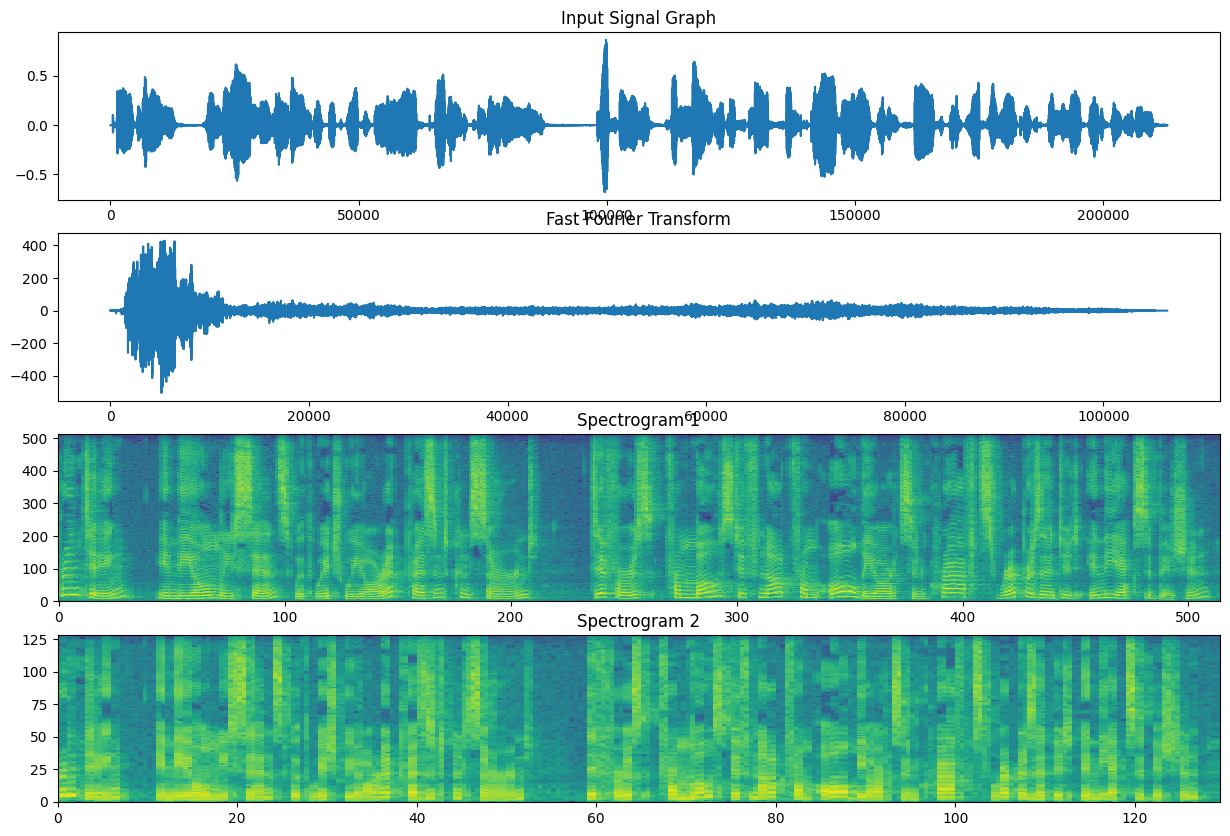

In [9]:
figure, axis = plt.subplots(nrows=4, figsize=(15,10))

LEN = 2000
x = tf.linspace(start=-LEN//2, stop=LEN//2, num=LEN)
print(signal_sample.shape)

# Input Signal
axis[0].plot(signal_sample)
axis[0].set_title('Input Signal Graph')

# fast Fourier transform
fft = tf.signal.rfft(signal_sample)
axis[1].plot(fft)
axis[1].set_title('Fast Fourier Transform')

# Short-time Fourier Transform
stftrm = tf.signal.stft(signal_sample, frame_length=1024, frame_step=512)
stftrm = tf.transpose(a=tf.abs(stftrm),perm=[1,0])
# print(stft)

power_stftrm = np.log(stftrm)
height_stftrm = power_stftrm.shape[0]
width_stftrm = power_stftrm.shape[1]

X = np.linspace(start=0,stop=height_stftrm,num=width_stftrm,dtype=int)
Y = range(height_stftrm)

# pseudocolor plot (colormesh) of a 2D array (matrix)
axis[2].pcolormesh(X, Y, power_stftrm)
axis[2].set_title("Spectrogram 1")

# ______________________

stftrm_2 = tf.signal.stft(signal_sample, frame_length=256, frame_step=128)
stftrm_2 = tf.transpose(a=tf.abs(stftrm_2),perm=[1,0])
# print(stft)

power_stftrm_2 = np.log(stftrm_2)
height_stftrm_2 = power_stftrm_2.shape[0]
width_stftrm_2 = power_stftrm_2.shape[1]

X = np.linspace(start=0,stop=height_stftrm_2,num=width_stftrm_2,dtype=int)
Y = range(height_stftrm_2)

# pseudocolor plot (colormesh) of a 2D array (matrix)
axis[3].pcolormesh(X, Y, power_stftrm_2)
axis[3].set_title("Spectrogram 2")

plt.show()

# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded. 


This stage depends on the dataset that is used. 

In [10]:
audio_texts = {}

# csvfile_path = "content\dataset\LJSpeech-1.1\metadata.csv"
csvfile_path = "content\dataset\LJSpeech-1.1\metadata.csv"
with open(file=csvfile_path, encoding='utf-8') as stream:
    for line in stream:
        file_name = line.strip().split('|')[0]
        file_text=line.strip().split("|")[1]
        audio_texts[str(file_name)]=file_text

In [11]:
# audio_texts

In [12]:
filepaths = ["content\\dataset\\LJSpeech-1.1\\wavs\\"+ filename +".wav" for filename in list(audio_texts.keys())]

transcriptions = [audio_texts[str(filename)].lower() for filename in list(audio_texts.keys())]

print(len(filepaths))
print(len(transcriptions))

13100
13100


In [13]:
dataset = tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

for record in dataset.take(count = 1):
    print(record)

(<tf.Tensor: shape=(), dtype=string, numpy=b'content\\dataset\\LJSpeech-1.1\\wavs\\LJ001-0001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'>)


In [14]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [15]:
vocabulary_eng=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary_eng)
print(len(vocabulary_eng))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [16]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary_eng, oov_token="")(label)
    return label

In [17]:
def get_spec(filepath,label):
    binary_audio = tf.io.read_file(filepath)
    waveform = decode_audio(binary_audio)
    waveform = tf.cast(waveform,tf.float32)
    
    spectrogram = tf.signal.stft(signals=waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
    spectrogram=tf.abs(spectrogram)
    label=get_label(label)
    return tf.expand_dims(spectrogram,axis=-1),label

In [18]:
# pipeline for processing dataset
# processes TensorFlow dataset by applying transformation function (get_spec), batching data & prefetching elements to optimize data loading. 

processed_dataset = (
    dataset.map(map_func=get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: 'C:\\Users\\0394D9~1\\AppData\\Local\\Temp\\__autograph_generated_file0xcgmvhg.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: 'C:\\Users\\0394D9~1\\AppData\\Local\\Temp\\__autograph_generated_file0xcgmvhg.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [19]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))

val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [20]:
len(train_dataset)

389

## 4. Deep Neural Network Architecture

## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced

<h2>Architecture of RNN Model followed</h2>

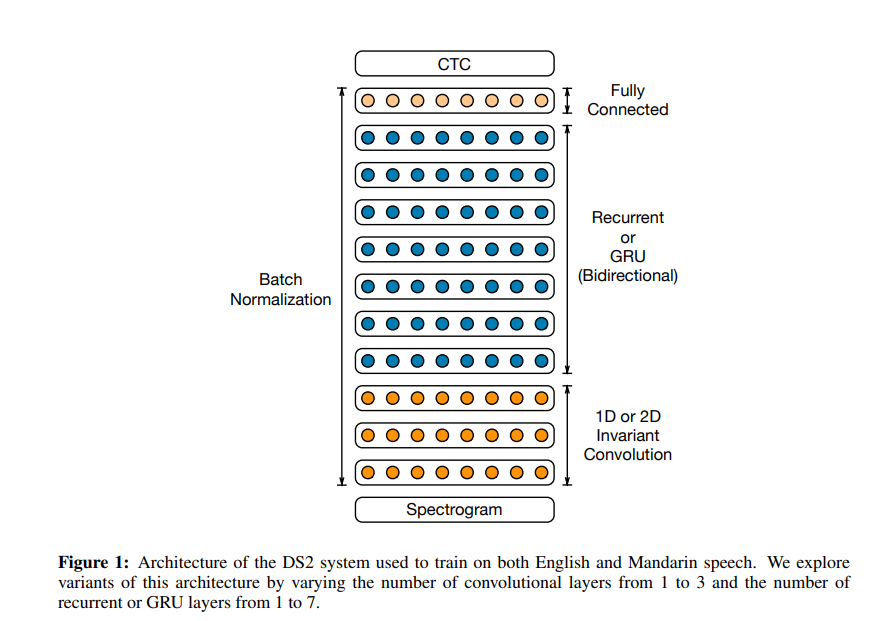

In [21]:
from IPython.display import Image, display

image_path = 'images/Architecture_Speech_Recognision_RNN.png'
display(Image(filename=image_path))

<h4>Modeling and Training</h4>

In [22]:
# A preprocessing layer which normalizes continuous features

normalization = tf.keras.layers.Normalization()

In [23]:
input_spectrogram = Input((None,129,1), name="input")

x=normalization(input_spectrogram)

# This 2D convolution layer creates a convolution kernel that is convolved with layer input to produce a tensor of outputs.
x=Conv2D(filters=32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)

# Normalize activations of previous layer for each given example in a batch independently, rather than across a batch like Batch Normalization.
x=LayerNormalization()(x)
x=Conv2D(filters=64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

# Bidirectional wrapper for RNNs
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary_eng)+1, activation="softmax")(x)

model = tf.keras.Model(inputs = input_spectrogram, outputs = output, name="RNN_Speech_Recog_v2")

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters 

<h4>Model_Parameters</h4>

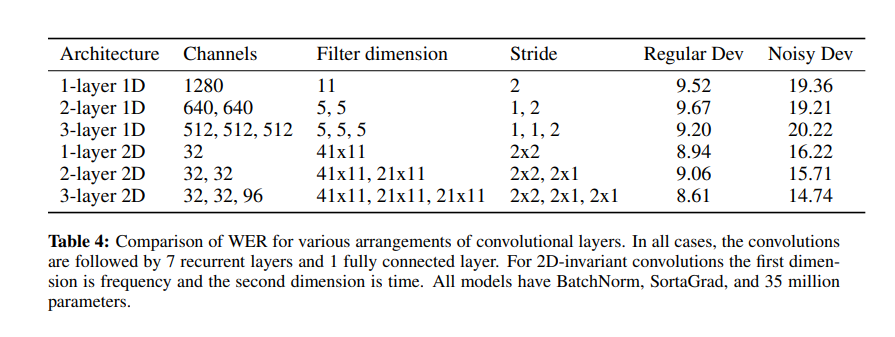

In [24]:
image_path = 'images/Parameters_RNN_Model.png'
display(Image(filename=image_path))

<h4>Number of layers (Including Input Layer) : 10</h4>

<h4>Number of units in each layer:</h4>

In [25]:
model.summary()

Model: "RNN_Speech_Recog_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizati  (None, None, 129, 1)      3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (Layer  (None, None, 65, 32)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Lay  (None, None, 33, 6

<h4>Total number of trainable parameters : 2810784 </h4>

# 5. Training the model 

__CTC Loss:__<br>
Connectionist Temporal Classification (CTC) is a machine learning technique commonly used for solving sequence-to-sequence problems, particularly in the field of speech recognition and handwriting recognition, but it has applications in various other domains as well.<br>
CTC is primarily used for tasks where input sequence and target sequence do not have a one-to-one alignment. In such cases, CTC can learn to align the sequences while making predictions. 

__Loss Calculation:__ CTC calculates a loss (CTC loss using connectionist temporal classification algorithm, taking into account sequence lengths) that measures the dissimilarity between the predicted sequence and the target sequence. The loss considers all possible alignments between the input and output sequences. It sums the probabilities of all valid alignments that lead to the target sequence.

In [26]:
@tf.keras.utils.register_keras_serializable()
def ctc_loss(y_true,y_pred):
    batch_size=tf.shape(y_pred)[0]
    pred_length=tf.shape(y_pred)[1]
    true_length=tf.shape(y_true)[1]

    pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
    true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

    return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [29]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR) # LR = 1e-4 as per paper
#     metrics=[Error_Rate_WER, Error_Rate_CER] #Will implement Accuracy seperately during testing
)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  callbacks=[early_stop],
  epochs=N_EPOCHS
)

<h4>Storing of Fitted Model History</h4>

In [ ]:
import pickle

# Save the history object to a file
with open('saved_models\history_fitted_model.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Later, when you want to load and use the history object
with open('saved_models\historyhistory_fitted_model.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

# Now, you can access training loss and metric values
print("Losses:", loaded_history['loss'])
print("Validation Losses:", loaded_history['val_loss'])
print("Metrics:", loaded_history['accuracy'])
print("Validation Metrics:", loaded_history['val_accuracy'])

<h4>Storage of Trained Model</h4>

In [31]:
# # !mkdir saved_models

# # # Save the model's architecture and weights
# # model.save(filepath='saved_models\RNN_Speech_Recog_B32_E100_P3.keras', save_format='keras')
# model.save(filepath='saved_models\RNN_Speech_Recog_v_1.keras', save_format='keras')

<h4>Loading of Trained Model</h4>

In [46]:
model = tf.keras.models.load_model(filepath='saved_models\RNN_Speech_Recog_B32_E100_P3.keras', compile=True)

In [ ]:
# evaluation_result = model.evaluate(val_dataset)
# print("Evaluation Result:", evaluation_result)

# 6. Test the model

__get_spec_inference__ function processes an audio file to obtain its spectrogram representation using following operations in sequence: <br>

reads binary data of an audio file --> convert binary audio data into a waveform --> casts waveform to a float32 data type (as it provides necessary precision for subsequent processing) --> compute Short-Time Fourier Transform (STFT - is a time-frequency representation of audio signal. FRAME_LENGTH and FRAME_STEP are parameters that determine window size and step size for STFT) of waveform --> computes magnitude (represents strength of each frequency component at each time step) of complex values in spectrogram --> expand dimensions (done to make data compatible with CNNs) of spectrogram by adding an extra dimension at end (axis=-1)

In [47]:
def get_spec_inference(filepath):
    audio_binary=tf.io.read_file(filepath)
    waveform=decode_audio(audio_binary)
    waveform=tf.cast(waveform,tf.float32)

    spectrogram=tf.signal.stft(waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

    spectrogram=tf.abs(spectrogram)

    return tf.expand_dims(spectrogram,axis=-1)

__decode__ function (designed to work with a CTC-based model) takes predicted labels (y_pred) & decodes them into a text sequence. This is a common operation in speech recognition or sequence-to-sequence tasks where model's predictions need to be converetd into human-readable text.

In [48]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary_eng)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary_eng[i] for i in output[0]]
  return ''.join(out)

__predict_text__ function takes an audio file path as input, extracts a spectrogram, and then uses a model to predict in numeric sequence & decodes them into a text sequence.

In [65]:
def predict_text(file_path):
    spectrogram = get_spec_inference(file_path)
    print(f'Spectrogram Representation of Sample Audio File is : {spectrogram.shape}\n \n')
    out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)

#     out_list=[vocabulary_eng[i] if i!=31 else "[LINK]" for i in out]
#     out_str="".join(out_list)
    
    return decode(tf.expand_dims(out,axis=0))

#     print(f'\n \n Decoded Text Sequence of Sample Audio File is : \n {decode(tf.expand_dims(out,axis=0))}')

<h4>Sample Audio File to Test</h4>

In [51]:
test_path="content\dataset\LJSpeech-1.1\wavs\LJ007-0164.wav"

predicted_text = predict_text(test_path)

print(f'\n \n Decoded Text Sequence of Sample Audio File is : \n {predicted_text}')

Spectrogram Representation of Sample Audio File is : (952, 129, 1)
 

1/1 [==============================] - 0s 193ms/step
tf.Tensor([  1 476], shape=(2,), dtype=int32)

 
 Decoded Text Sequence of Sample Audio File is : 
 forbed the fatis chato of ahope that in a soel so unfaivrable fr moreal cuter                                                                                                                                                                                                                                                                                                                                                                                                               


In [52]:
def get_original_text_from_audio(filepaths, test_path):
    
    filenm = os.path.basename(test_path)

    found_row = None
    found_index = None

    for i, item in enumerate(filepaths):
        if filenm in item:
            found_row = item
            found_index = i
            break  # Exit the loop once a match is found

    if found_row is not None:
        print(f"Found '{found_row}' at index {found_index}")
    else:
        print(f"No match found for '{filenm}'")
        
    return found_index, filenm

#     print(f"Content of this row is : '{transcriptions[found_index]}'")

In [53]:
index_searched, name_file = get_original_text_from_audio(filepaths, test_path)

original_text = transcriptions[index_searched]

print(f'\n \n Name of Sample Audio File is : {name_file}')

print(f'\n \n Original Decoded Text Sequence of Sample Audio File is : \n {original_text}')

print(f'\n \n Decoded Text Sequence of Sample Audio File is : \n {predicted_text}')

Found 'content\dataset\LJSpeech-1.1\wavs\LJ007-0164.wav' at index 1889

 
 Name of Sample Audio File is : LJ007-0164.wav

 
 Original Decoded Text Sequence of Sample Audio File is : 
 forbid the faintest shadow of a hope that in a soil so unfavorable for moral culture

 
 Decoded Text Sequence of Sample Audio File is : 
 forbed the fatis chato of ahope that in a soel so unfaivrable fr moreal cuter                                                                                                                                                                                                                                                                                                                                                                                                               


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history. 
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.

__Generally for Speech Recognizition, Training and validation accuracy history are not performed during Model training, but Accuracy is calculated during testing of model.__


__So, Plotting of Training & Validation Accuracy History is not applicable for Speech Recognizition__

Similarly, Report values for preformance study metrics like accuracy, precision, recall, F1 Score are not applicable here.

 __Training and Validation Loss History__

In [ ]:
# Access and display training history
print("Training history:")
print(history.history)

# Display final loss and accuracy
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
print(f"Final training loss: {final_loss:.4f}")
print(f"Final training accuracy: {final_accuracy:.4f}")

# If validation data is available, display validation loss and accuracy
if 'val_loss' in history.history and 'val_accuracy' in history.history:
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"Final validation loss: {final_val_loss:.4f}")
    print(f"Final validation accuracy: {final_val_accuracy:.4f}")

__Reporting of Testing Accuracy and Loss__

Speech recognition is a sequence-to-sequence problem, and evaluating the performance of a speech recognition system typically involves metrics that are specific to this task. Below are some common metrics used for speech recognition:

__Word Error Rate (WER):__ WER is one of the most widely used metrics for speech recognition. It measures the number of substitutions, insertions, and deletions needed to align the recognized words with the reference (ground truth) words. Lower WER values indicate better performance.

__Character Error Rate (CER):__ CER is similar to WER but operates at the character level instead of the word level. It measures the number of substitutions, insertions, and deletions needed to align the recognized characters with the reference characters.

In [54]:
import Levenshtein

In [55]:
# Define a function to calculate Word Error Rate (WER)
def wer(recognized, reference):
    recognized = recognized.split()
    reference = reference.split()
    # Use python-Levenshtein to calculate edit distance
    distance = Levenshtein.distance(recognized, reference)
    return distance / len(reference)

In [56]:
# Define a function to calculate Character Error Rate (CER)
def cer(recognized, reference):
    # Use python-Levenshtein to calculate edit distance
    distance = Levenshtein.distance(recognized, reference)
#     Calculates the minimum number of insertions, deletions, and substitutions required to change one sequence into 
# other according to Levenshtein with custom costs for insertion, deletion and substitution

    return distance / len(reference)

In [57]:
def Error_Rate_WER(recognized_text, reference_text):
    wer_score = wer(recognized_text, reference_text)
    return wer_score

In [58]:
def Error_Rate_CER(recognized_text, reference_text):
    cer_score = cer(recognized_text, reference_text)
    return cer_score

In [59]:
def Error_Rate(recognized_text, reference_text):
    import Levenshtein

    # Calculate WER and CER for your model's output
    wer_score = wer(recognized_text, reference_text)
    cer_score = cer(recognized_text, reference_text)

    # Print the results
    print(f"Word Error Rate (WER): {wer_score:.4f}")
    print(f"Character Error Rate (CER): {cer_score:.4f}")

In [60]:
Error_Rate(predicted_text, original_text)

Word Error Rate (WER): 0.6250
Character Error Rate (CER): 4.9405


<h4>Calculation of Loss (WER, CER) & Accuracy(1-WER) for range of test audio files</h4>

Implementation of __ctc_loss__ function already shown before model compilation & it depends on specific loss function used for speech recognition model. In speech recognition, a common loss function is Connectionist Temporal Classification (CTC) loss.

<h4>Selection of Range of Test Audio Files & Display of their Actual Transcripts</h4>

In [62]:
# filepaths
# transcriptions

# Define the range of indices you want to extract
start_index = 20  # Inclusive start index
end_index = 23   # Exclusive end index

# Use list slicing to extract values within the specified range
selected_filepaths = filepaths[start_index:end_index]
reference_transcripts = transcriptions[start_index:end_index]

# Print the selected values
for trs in reference_transcripts:
    print(f'\n{trs}')


the earliest book printed with movable type, the aforesaid gutenberg bible, is printed in letters which are an exact imitation

of the more formal ecclesiastical writing which obtained at that time; this has since been called "missal type,"

and was in fact the kind of letter used in the many splendid missals, psalters, etc., produced by printing in the fifteenth century.


In [66]:
# Predict transcripts using trained RNN model and store them in list
predicted_transcripts = [predict_text(audio) for audio in selected_filepaths]

for i in predicted_transcripts:
    print(f'{i}\n\n')
    
for j in reference_transcripts:
    print(f'{j}\n\n')

    
# Calculate Word Error Rate (WER) and Character Error Rate (CER)
wer_scores = []
cer_scores = []

for predicted, reference in zip(predicted_transcripts, reference_transcripts):
    
#     print(f'{predicted} :: {reference}')
    wer_score = wer(predicted, reference)
    cer_score = cer(predicted, reference)
    wer_scores.append(wer_score)
    cer_scores.append(cer_score)

# Calculate accuracy based on a similarity threshold
similarity_threshold = 0.9  # Adjust as needed
accurate_predictions = [score <= similarity_threshold for score in wer_scores]
accuracy = np.mean(accurate_predictions)

# Print evaluation results
print(f"Mean WER: {np.mean(wer_scores):.4f}")
print(f"Mean CER: {np.mean(cer_scores):.4f}")
print(f"Accuracy: {accuracy:.4f}")

Spectrogram Representation of Sample Audio File is : (1482, 129, 1)
 

1/1 [==============================] - 1s 523ms/step
tf.Tensor([  1 741], shape=(2,), dtype=int32)
Spectrogram Representation of Sample Audio File is : (1214, 129, 1)
 

1/1 [==============================] - 0s 388ms/step
tf.Tensor([  1 607], shape=(2,), dtype=int32)
Spectrogram Representation of Sample Audio File is : (1454, 129, 1)
 

1/1 [==============================] - 0s 418ms/step
tf.Tensor([  1 727], shape=(2,), dtype=int32)
the arliist book printid with movable tipe the ofore said gtinbero bivl is printed in letters which are annenxactimitation                                                                                                                                                                                                                                                                                                                                                                                

<h4>Plot of Training & Validation Loss History</h4>

In [ ]:
loss[['loss','val_loss']].plot()

<h4>Display of Confusion Matrix for Testing Dataset</h4>

Confusion Matrix & Classification Report are applicable for Classification Model, but not for Speech Recognizition Model